In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [ ]:
def OutlierDetector(data):
    '''Detects outliers in a given pandas Series using the IQR method.
    Args:
        data (pd.Series): The input data series to check for outliers.
    Returns:
        pd.Series: A series containing the outliers.
    Raises:
        ValueError: If the input data is not a pandas Series.   
    
    '''
    
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3 - q1
    lower, upper = q1 - 1.5*iqr, q3 + 1.5*iqr
    return data[(data < lower) | (data > upper)]


In [ ]:
def DefaultFlagGenerator(df):
    default_flag = (
        (df['payment_delinquency_count'] >= 3).astype(int) +
        (df['over_indebtedness_flag'] == 1).astype(int) +
        (df['financial_stress_score'] >= 9).astype(int) +
        (df['bnpl_debt_ratio'] >= 1.8).astype(int) +
        (df['credit_limit_utilisation'] >= 95).astype(int)
        ) >= 3 # Must meet at least 3 of the 5 conditions
    df['default_flag'] = default_flag.astype(int)
    return df

In [ ]:
def Scaler(data, continuous_cols, binary_cols):
    scaler = StandardScaler()
   # Scale the continuous columns
    scaled_continuous = scaler.fit_transform(data[continuous_cols])
    scaled_continuous_df = pd.DataFrame(scaled_continuous, columns=continuous_cols, index=data.index)
    
    # Combine binary columns and scaled continuous columns
    result = pd.concat([data[binary_cols], scaled_continuous_df], axis=1)
    
    return result

In [ ]:
#open file bnpl
data = pd.read_csv('bnpl.csv')
data.info()


In [ ]:
for column in data.select_dtypes(include=['float64', 'int64']).columns:
    outliers = OutlierDetector(data[column])
    print(f"Outliers in {column}:\n", outliers)


In [ ]:
data = DefaultFlagGenerator(data)
data_clean = data.drop(columns=['CustomerID'])

In [ ]:
binary_cols=[col for col in data_clean.columns if data_clean[col].nunique() == 2]
continuous_cols = [col for col in data_clean.columns if data_clean[col].nunique() > 2]
print("Binary columns:", binary_cols)
print("Continuous columns:", continuous_cols)

In [ ]:

data_scaled = Scaler(data_clean,continuous_cols, binary_cols)
data_scaled.to_csv('bnpl_scaled.csv', index=False)
print("Data processing complete. Scaled data saved to 'bnpl_scaled.csv'.")

In [ ]:
# run histograms for continuous columns

for column in continuous_cols:
    plt.figure(figsize=(10, 6))
    plt.hist(data_scaled[column], bins=30, edgecolor='black')
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.grid(axis='y', alpha=0.75)
    #save the histogram as a png file in a folder named 'histograms'
    plt.savefig(f'histograms/{column}_histogram.png')


In [ ]:
#check for outliers in each column
for column in data_scaled.select_dtypes(include=['float64', 'int64']).columns:
    outliers = OutlierDetector(data_scaled[column])
    if not outliers.empty:
        print(f"Outliers in {column}:\n", outliers)
    else:
        print(f"No outliers detected in {column}.")

In [ ]:
#print boxplots for continuous columns
for column in continuous_cols:
    plt.figure(figsize=(10, 6))
    plt.boxplot(data_scaled[column])
    plt.title(f'Boxplot of {column}')
    plt.ylabel(column)
    plt.grid(axis='y', alpha=0.75)
    #save the boxplot as a png file in a folder named 'boxplots'
    #plt.savefig(f'boxplots/{column}_boxplot.png')

In [ ]:
#check the balance of the binary columns
for column in binary_cols:
    balance = data_scaled[column].value_counts(normalize=True)
    print(f"Balance of {column}:\n", balance)
    plt.figure(figsize=(8, 5))
    balance.plot(kind='bar')
    plt.title(f'Balance of {column}')
    plt.xlabel(column)
    plt.ylabel('Proportion')
    plt.grid(axis='y', alpha=0.75)
    plt.savefig(f'balances/{column}_balance.png')

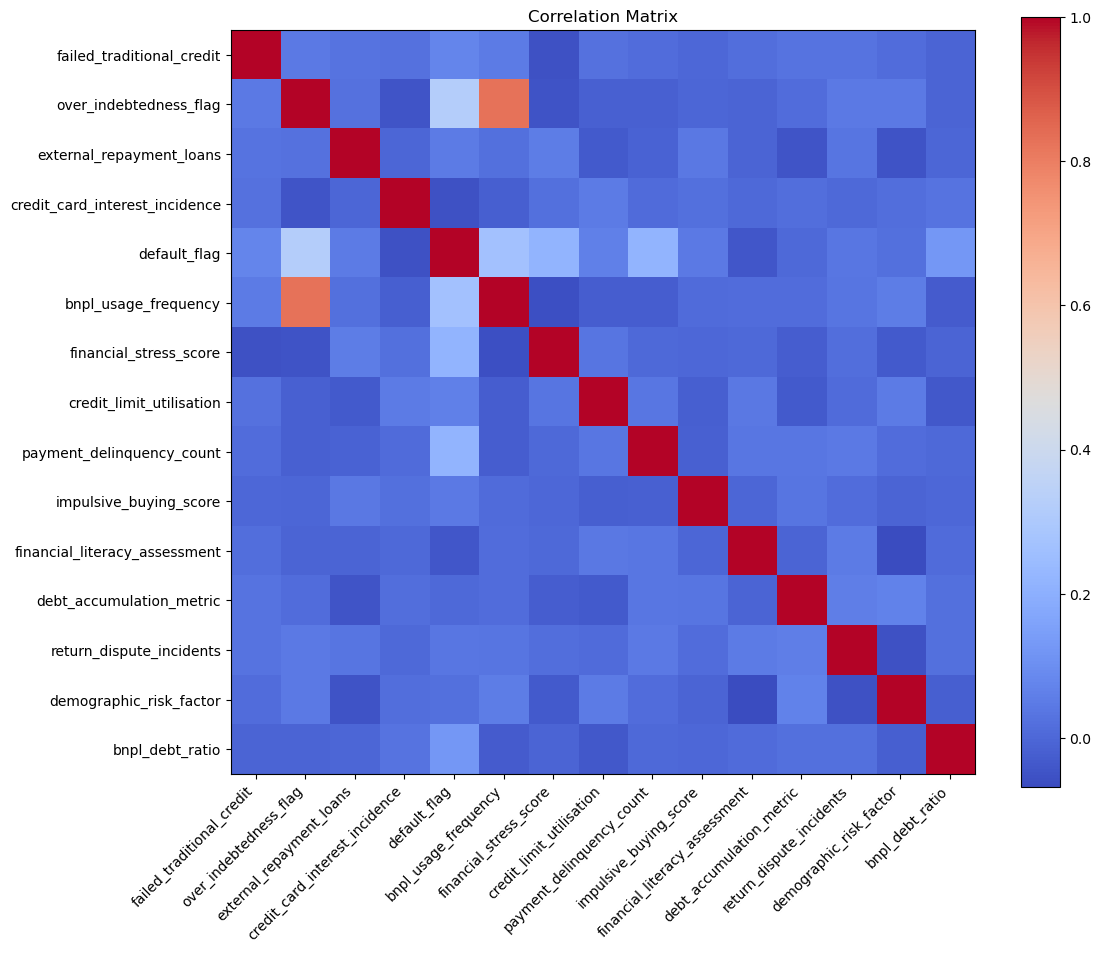

In [74]:
#get the correlation matrix
correlation_matrix = data_scaled.corr()
plt.figure(figsize=(12, 10))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.title('Correlation Matrix')
#change the x and y ticks to the column names
plt.xticks(ticks=np.arange(len(data_scaled.columns)), labels=data_scaled.columns, rotation=45, ha='right')
plt.yticks(ticks=np.arange(len(data_scaled.columns)), labels=data_scaled.columns)
plt.savefig('correlation_matrix.png')

<Figure size 1000x600 with 0 Axes>

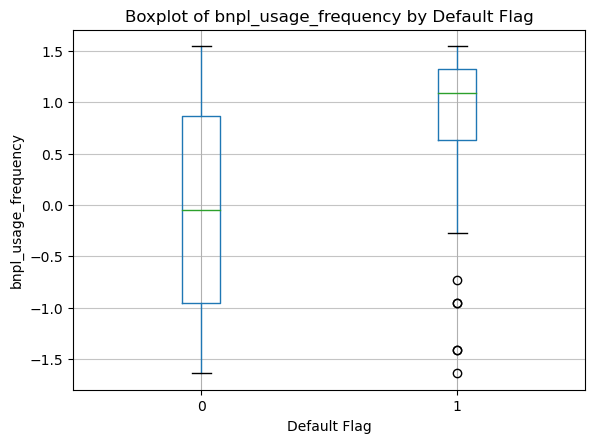

<Figure size 1000x600 with 0 Axes>

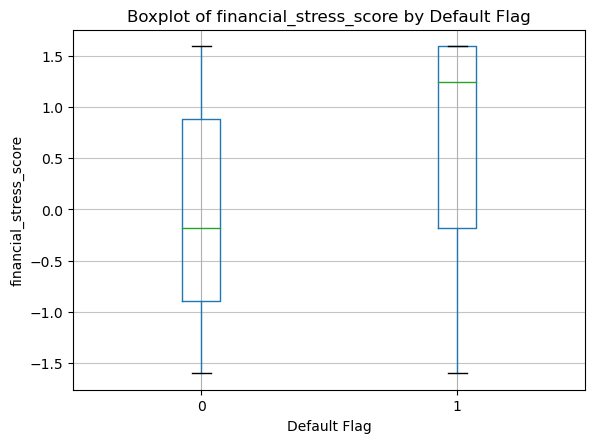

<Figure size 1000x600 with 0 Axes>

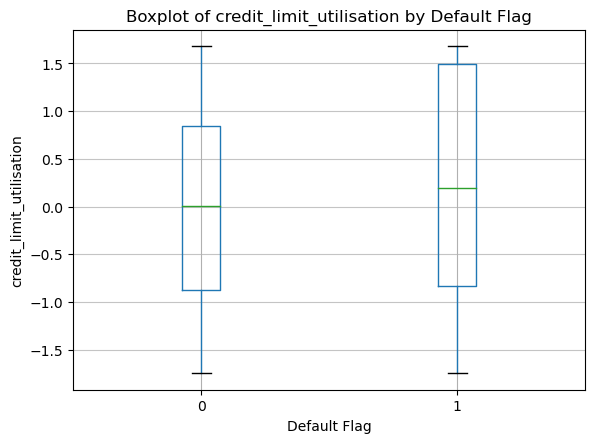

<Figure size 1000x600 with 0 Axes>

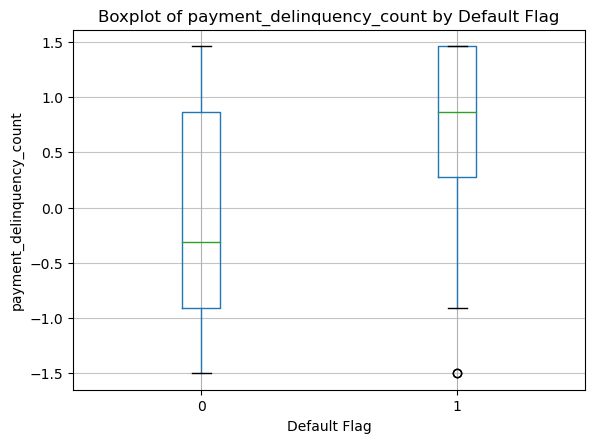

<Figure size 1000x600 with 0 Axes>

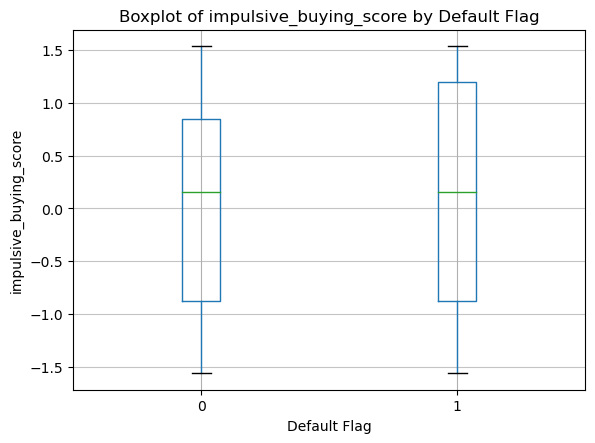

<Figure size 1000x600 with 0 Axes>

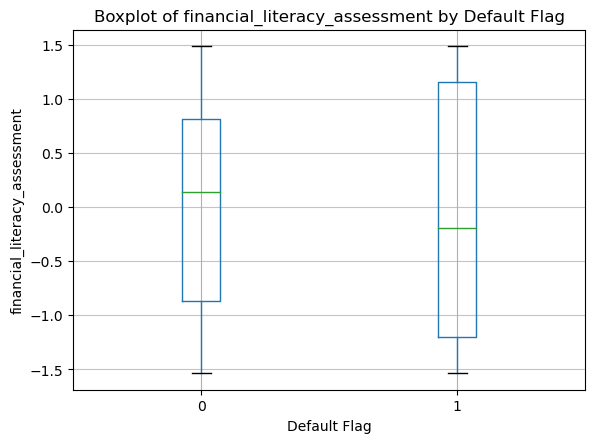

<Figure size 1000x600 with 0 Axes>

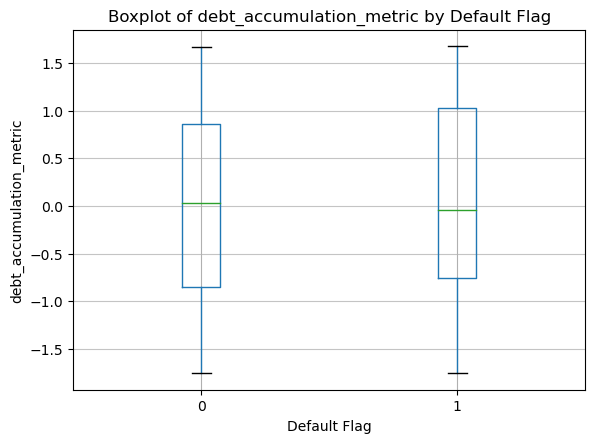

<Figure size 1000x600 with 0 Axes>

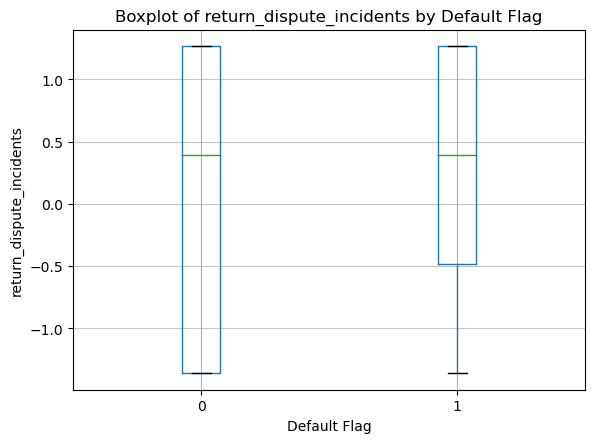

<Figure size 1000x600 with 0 Axes>

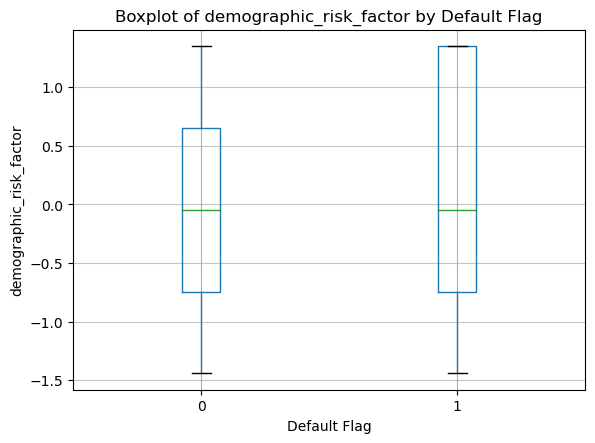

<Figure size 1000x600 with 0 Axes>

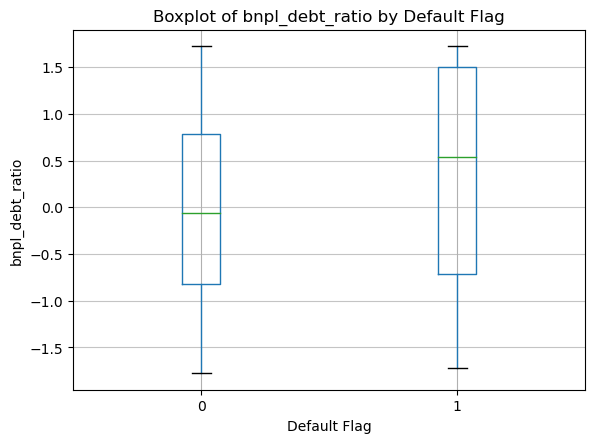

In [80]:
#plot 2 boxplots for each column one with default flag 0 and one with default flag 1
for column in continuous_cols:
    plt.figure(figsize=(10, 6))
    data_scaled.boxplot(column=column, by='default_flag')
    plt.title(f'Boxplot of {column} by Default Flag')
    plt.suptitle('')
    plt.xlabel('Default Flag')
    plt.ylabel(column)
    plt.grid(axis='y', alpha=0.75)
    plt.savefig(f'boxplots/{column}_boxplot_by_default_flag.png')

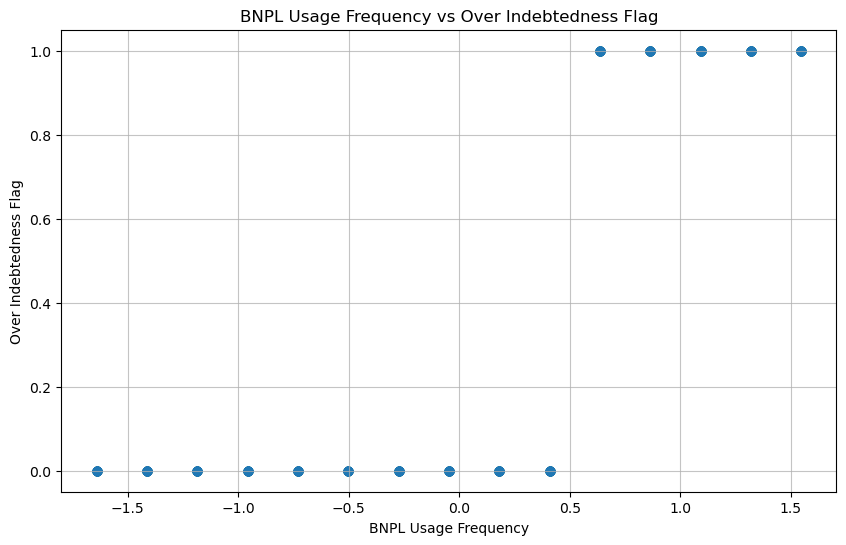

In [82]:
#plot a scatter plot for BNPL_usage_frequency vs over_indebtedness_flag
plt.figure(figsize=(10, 6))
plt.scatter(data_scaled['bnpl_usage_frequency'], data_scaled['over_indebtedness_flag'], alpha=0.5)
plt.title('BNPL Usage Frequency vs Over Indebtedness Flag')
plt.xlabel('BNPL Usage Frequency')
plt.ylabel('Over Indebtedness Flag')
plt.grid(alpha=0.75)
plt.savefig('BNPL_usage_frequency_vs_over_indebtedness_flag.png')